In [5]:
import numpy as np
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from core.cluster_validation import morphotopes_to_etcs

In [6]:
regions_datadir = "/data/uscuni-ulce/"
model_params = '_75_0_None_None_False'

In [3]:
# v = 'v3'
# regional_clusters = pd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/regional_clusters_{v}.pq')[0]
# final_clusters = pd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/final_clusters_{v}.pq')
# cdata = pd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/cdata_{v}.pq')
# regional_ward_morphotopes_data = pd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/cluster_input_data_{v}.pq')
# linkage_matrix = np.load(f'/data/uscuni-ulce/processed_data/clusters/kmeans_linkage_{v}.npy')

In [7]:
# direct bisecting kmeans

morphotopes_dir = '/data/uscuni-ulce/processed_data/morphotopes/'

# linkage_matrix = np.load('/data/uscuni-ulce/taxonomies/kmeans_linkage_morphotopes.npy')
linkage_matrix = np.load('../data/kmeans_linkage_umap_embedded_morphotopes.npy')

regions_datadir = "/data/uscuni-ulce/"
region_hulls = gpd.read_parquet(
        regions_datadir + "regions/" + "cadastre_regions_hull.parquet"
)

def read_morphotopes_data(model_params):
    
    data = []
    for region_id, _ in region_hulls.iterrows():
        region_morphotope_data = pd.read_parquet(f'{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq')
        region_morphotope_data.index = str(region_id) + '_' + region_morphotope_data.index.str[:]
        data.append(region_morphotope_data)
    
    data = pd.concat(data)
    return data
    
morphotopes_data = read_morphotopes_data(model_params)
morphotopes_data = morphotopes_data[~morphotopes_data.index.str.endswith('-1')]
morphotopes_data = morphotopes_data.iloc[:, :-1]
regional_ward_morphotopes_data = morphotopes_data

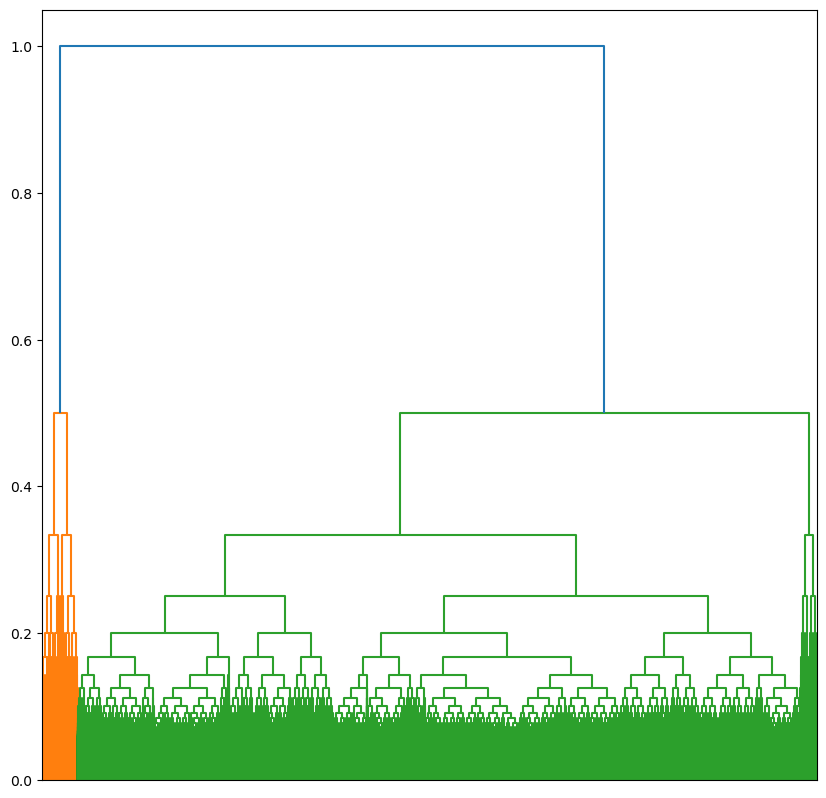

In [8]:
## final dendrogram
fig,ax = plt.subplots(figsize=(10,10))
_ = dendrogram(linkage_matrix,ax=ax, no_labels=True)

In [9]:
final_cutoff = 1/4 -0.00001
clusters = fcluster(linkage_matrix, t=final_cutoff, criterion='distance')
final_clusters = pd.Series(clusters, regional_ward_morphotopes_data.index)
final_clusters.value_counts()

11    193779
12    121648
9     102341
10     70372
1       4849
8       4698
7       4333
3       3799
13      3111
16      3106
2       3052
15      2949
14      1998
5       1680
6       1592
4        288
Name: count, dtype: int64

In [10]:
final_clusters.value_counts().value_counts()

count
193779    1
121648    1
102341    1
70372     1
4849      1
4698      1
4333      1
3799      1
3111      1
3106      1
3052      1
2949      1
1998      1
1680      1
1592      1
288       1
Name: count, dtype: int64

### Plotting

In [11]:
from core.cluster_validation import get_color
final_colors = pd.DataFrame(get_color(final_clusters.values), final_clusters.values).drop_duplicates()
final_colors.loc[-1] = [255,255,255]

In [12]:
region_id = 69333 

# region_id = 99886 # bratislava

# region_id = 151676 # vilnius

# region_id = 8707 # mainz/frankfurt
# region_id = 5883 #  freiburg
# region_id = 38679 #munich
# region_id = 55763 # berlin

# region_id = 86873 # vienna

# region_id = 107131 # krakow


# region_id= 66593

In [13]:
etcs = morphotopes_to_etcs(region_id, etcs=False, model_params=model_params)

In [14]:
# etcs = morphotopes_to_etcs(69333, etcs=False, model_params=model_params)
# etcs2 = morphotopes_to_etcs(91011, etcs=False, model_params=model_params)
# etcs3 = morphotopes_to_etcs(93167, etcs=False, model_params=model_params)
# etcs4 = morphotopes_to_etcs(63756, etcs=False, model_params=model_params)
# etcs5 = morphotopes_to_etcs(107131, etcs=False, model_params=model_params)

# etcs = pd.concat((etcs, etcs2, etcs3, etcs4, etcs5), ignore_index=True)

In [15]:



# ## relabel
# ### regional_clusters = morphotopes -> regional_clusters
# ### final_clusters = regional_clusters -> final_clusters
# etcs['final'] = etcs['morph'].map(lambda x: final_clusters.loc[regional_clusters.loc[x]] if x in regional_clusters else -1)
# etcs['regional'] = etcs['morph'].map(lambda x: regional_clusters.loc[x] if x in regional_clusters else "-1")


# direct kmeans
etcs['final'] = etcs['morph'].map(lambda x: final_clusters.loc[x] if x in morphotopes_data.index else -1)
etcs['regional'] = etcs['morph']

In [16]:
etcs['geometry'] = etcs.simplify(1).to_crs(epsg=4326).make_valid()
etcs = etcs[etcs['geometry'].geom_type == 'Polygon']

In [17]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(etcs, opacity=.7)

CPU times: user 1.07 s, sys: 119 ms, total: 1.18 s
Wall time: 1.18 s


In [18]:
from sidecar import Sidecar
sc = Sidecar(title=f'Final Clusters - {final_cutoff}')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.DarkMatter)
with sc:
    display(m)

In [19]:
from core.cluster_validation import get_color
layer.get_fill_color = final_colors.loc[etcs.final].values.astype('uint8')

### Interactive dendro

In [38]:
from core import interactive_dendrogram
import jscatter
import seaborn as sns


def get_subcluster_children(focus):
    if focus < n:
        return [focus]
    child, parent = linkage_matrix[focus - n, 0].astype(int), linkage_matrix[focus - n, 1].astype(int)
    children_ids = interactive_dendrogram.get_children(linkage_matrix, child, parent)
    children_morphotopes = regional_ward_morphotopes_data.iloc[children_ids].index
    return children_morphotopes

In [39]:
scatter_df, lines = interactive_dendrogram.get_dendrogram_scatter_data(linkage_matrix)

In [40]:
## cutoff linkage plot at level

cutoff_level = 11

cutoff_value = 1/(cutoff_level+1)
plot_scatter = scatter_df[scatter_df.y > cutoff_value]
plot_lines = [l for l in lines if l.vertices[1][1] > cutoff_value]

In [41]:
scatter = jscatter.Scatter(data=plot_scatter, x='x', y='y', annotations=plot_lines, height=640, width=1280)
scatter.axes(grid=True)

In [42]:
scatter.show()

In [75]:
focus = plot_scatter.iloc[scatter.selection()[0], -1]

n = linkage_matrix.shape[0] + 1

left, right = linkage_matrix[focus - n, 0].astype(int), linkage_matrix[focus - n, 1].astype(int)
left_children = get_subcluster_children(left)
right_children = get_subcluster_children(right)

# branch = np.union1d(left_children, right_children)

cluster_colors = np.full((etcs.shape[0], 3), 0) # everything black
cluster_colors[etcs.regional.isin(left_children)] = [141,211,199] # left blue - 1
cluster_colors[etcs.regional.isin(right_children)] = [255,255,179] # right yellow - 2
layer.get_fill_color = cluster_colors.astype('uint8')

In [219]:
# top 20 differences between the right sub-branch and the left sub-branch of the selected node.

left_data = regional_ward_morphotopes_data.loc[left_children].mean()
right_data = regional_ward_morphotopes_data.loc[right_children].mean()

diffs = (left_data - right_data)
diffs = diffs[(diffs ** 2).sort_values(ascending=False).index].head(20)
diffs

sdbAre    4.059986
sdbPer    3.234200
ssbCCo   -2.078855
ssbCor    2.014940
ssbERI   -1.706823
sdcAre    1.059056
ssbElo   -1.002316
mdcAre    0.832123
limLPS   -0.827982
sdsSWD   -0.715818
mibFR     0.709644
mibSCo    0.709644
sdcLAL    0.615772
linP4W    0.589773
mibCCo   -0.581242
mibLAL    0.567260
micBAD    0.531227
mibElo   -0.477596
lcdMes    0.404891
sdsSPW    0.374064
dtype: float64